## Assignment

- Use the same data you chose for the previous lesson, or get new data.
- Do train/test split. Report your mean absolute error on the train and test set, for these forecasts:
  - Mean Baseline
  - Naive Baseline (Last Observation)
  - Prophet forecast (you can choose the parameters or use the defaults)
- Do time series cross-validation, using these Prophet functions:
  - cross_validation
  - performance_metrics
  - plot_cross_validation_metric
- Commit your notebook to your fork of the GitHub repo.

### Stretch Challenges
- **Share your visualizations on Slack!**
- Use the Wikimedia Pageviews API to get data.
- [Get daily weather station data](https://www.ncdc.noaa.gov/cdo-web/search) from the NOAA (National Oceanic and Atmospheric Administration). User Prophet to forecast the weather for your local area. 
- Adjust your forecasts with Prophet's [changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html) and [holidays](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html) options. In addition to Prophet's documentation, read Will Koehrsen's blog post, [Time Series Analysis in Python](https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a). **How do these parameters affect your error metrics?**
- Learn more about how Prophet works. Read the [tweestorm with animated GIFs](https://twitter.com/seanjtaylor/status/1123278380369973248) by Prophet developer Sean J. Taylor, or his [research paper](https://peerj.com/preprints/3190/).

In [8]:
#import libs 
%matplotlib inline
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

## Get Data

In [9]:
#structure wikimedia pageview api request 
project = 'en.wikipedia'
access = 'all-access'
agent = 'user'
article = 'Barkley_Marathons'
granularity = 'daily'
start = '2015070100'
end = '2019052700'

#make wikimedia api GET request
endpoint = f"/metrics/pageviews/per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}"
url = 'https://wikimedia.org/api/rest_v1' + endpoint
resp = requests.get(url)

#ensure the request is successful 
assert resp.status_code == 200 

In [10]:
#create dataframe from the wikimedia GET request's response body
bark_mara = pd.DataFrame(resp.json()['items'])

#rename timestamp and views columns for use with Prophet 
bark_mara = bark_mara.rename(columns={'timestamp':'ds', 'views':'y'})

#cast ds column to datetime data type with formating 
bark_mara['ds'] = pd.to_datetime(bark_mara['ds'], format='%Y%m%d%H')

## Train / Test Split

In [11]:
#Set index to ds col 
bark_mara = bark_mara.set_index('ds')

In [12]:
#Split train/test datasets by time window 
train = bark_mara['2015':'2017']
test = bark_mara['2018':'2019']

In [13]:
#Reset indexes for both dataframes 
train = train.reset_index()
test = test.reset_index()

TypeError: float() argument must be a string or a number, not 'Period'

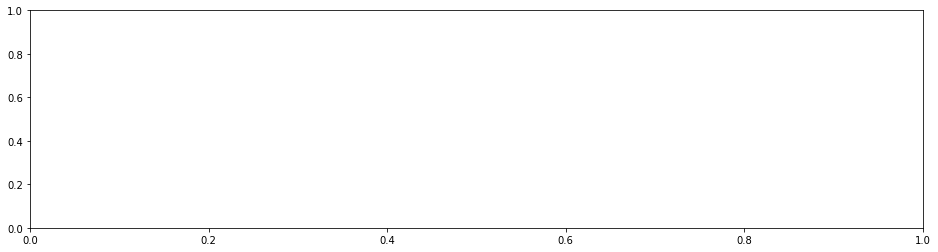

In [14]:
#Plot train and test datasets 
ax = train.plot(x='ds',y='y',color='blue',figsize=(16,4))
test.plot(x='ds',y='y',color='red',ax=ax)
plt.title('Daily Pageviews for The Barkley Marathons');

## Mean Baseline

In [ ]:
#create two new columns for the mean baseline of the train dataset
train['mean_baseline'] = train['y'].mean()
test['mean_baseline'] = train['y'].mean()

#print means
train['y'].mean(), test['y'].mean()

In [ ]:
#Plot train and test datasets with the mean baseline 
ax = train.plot(x='ds',y='y',color='blue',figsize=(16,4))
test.plot(x='ds',y='y',color='red',ax=ax)
train.plot(x='ds',y='mean_baseline',color='black',ax=ax)
test.plot(x='ds',y='mean_baseline',color='black',ax=ax)
plt.title('Daily Pageviews for The Barkley Marathons');

## Naive Baseline (Last Observation)

In [ ]:
train['naive_baseline'] = train['y'].shift(1).bfill()
train_last_observation = train['naive_baseline'].iloc[-1]
test['naive_baseline'] = train_last_observation

In [ ]:
ax = train.plot(x='ds', y='y', color='blue', figsize=(16,4))
test.plot(x='ds', y='y', color='red', ax=ax)
train.plot(x='ds', y='naive_baseline', color='black', ax=ax)
test.plot(x='ds', y='naive_baseline', color='black', ax=ax);

## Prophet Forecast

In [ ]:
bark_mara_model = Prophet(daily_seasonality=False)
bark_mara_model.fit(train)
train_forecast = bark_mara_model.predict(train)
test_forecast = bark_mara_model.predict(test)

In [ ]:
train_forecast.head()

In [ ]:
ax = train.plot(x='ds', y='y', color='blue', label='Train', figsize=(16,4))
test.plot(x='ds',y='y',color='red',label='Test',ax=ax)
train_forecast.plot(x='ds', y='yhat', color='black', label='Prophet forecast, train', ax=ax)
plt.title('Daily Pageviews for The Barkley Marathons');

## MAE for Each Forecast

### Mean Baseline

In [ ]:
train_mae = mean_absolute_error(train['y'], train['mean_baseline'])
test_mae = mean_absolute_error(test['y'], test['mean_baseline'])
train_mae, test_mae

### Naive Baseline

In [ ]:
train_mae = mean_absolute_error(train['y'], train['naive_baseline'])
test_mae = mean_absolute_error(test['y'], test['naive_baseline'])
train_mae, test_mae

### Prophet

In [ ]:
train_mae = mean_absolute_error(train['y'], train_forecast['yhat'])
test_mae = mean_absolute_error(test['y'], test_forecast['yhat'])
train_mae, test_mae

## Cross Validation

In [ ]:
#Cross Validation
df_cv = cross_validation(bark_mara_model, horizon='180 days')

In [ ]:
#performance_metrics
performance_metrics(df_cv).head()

In [ ]:
#plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.title('Cross Validation MAE for The Barkley Marathons Pageviews');

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.title('Cross Validation MAPE for The Barkley Marathons Pageviews');